In [13]:
import pandas as pd
import numpy as np
import sklearn
import re
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
PassengerId = test['PassengerId']

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
full_data = [train, test]
train['HasCabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['HasCabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    

/Users/johngoddard/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
dataset.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Name_length,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,0,16,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,0,32,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,0,25,1,1,1


In [10]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [11]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,HasCabin,Name_length,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,23,2,0,1
1,1,1,0,2,0,3,1,1,51,2,0,3
2,1,3,0,1,0,1,0,0,22,1,1,2


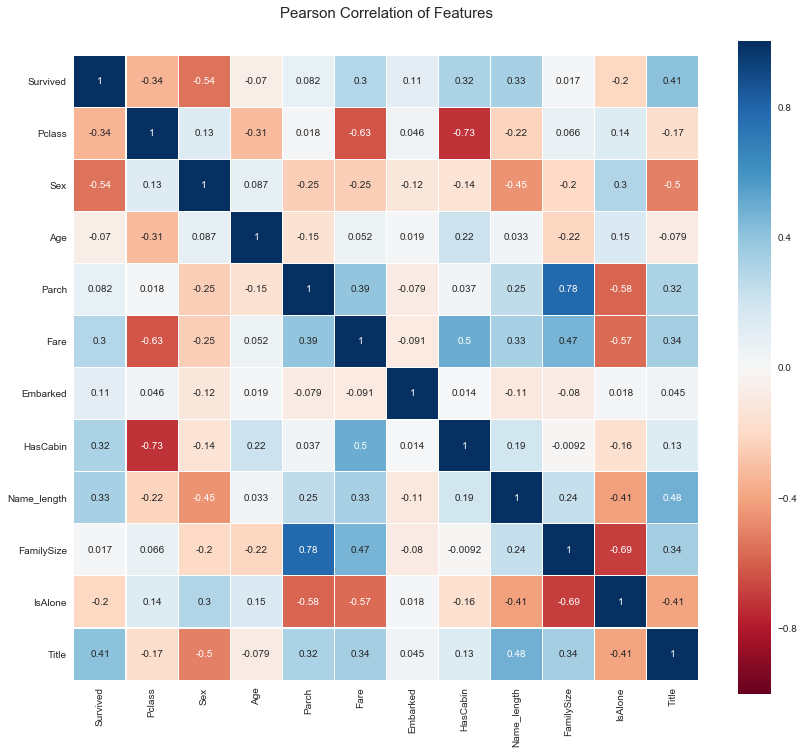

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

/Users/johngoddard/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/johngoddard/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


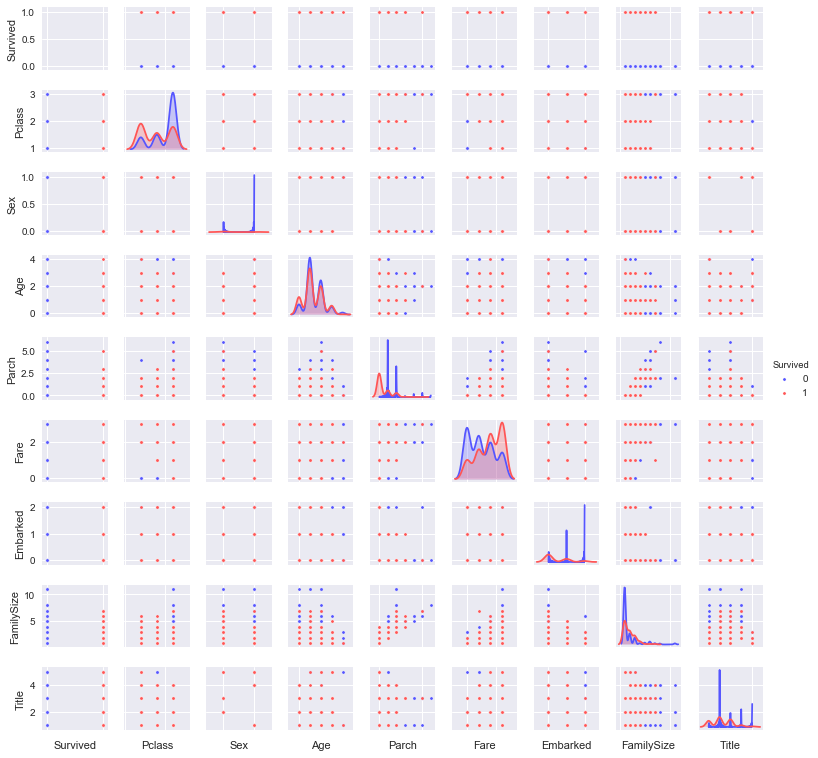

In [15]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [27]:
train.head(3)
len(train)

891

In [28]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(train))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [29]:
train_set, test_set = split_train_test(train, .2)

In [31]:
len(train_set)
len(test_set)

178

In [32]:
train_X = train_set.drop('Survived', axis=1)
train_labels = train_set['Survived'].copy()

In [33]:
test_X = test_set.drop('Survived', axis=1)
test_labels = test_set['Survived'].copy()

In [34]:
test_X.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,HasCabin,Name_length,FamilySize,IsAlone,Title
328,3,0,1,1,2,0,0,46,3,0,3
640,3,1,1,0,0,0,0,22,1,1,1
697,3,0,2,0,0,2,0,32,1,1,2


In [35]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

In [36]:
voting_clf.fit(train_X, train_labels)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         n_jobs=1, voting='hard', weights=None)

In [37]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_X, train_labels)
    y_pred = clf.predict(test_X)
    print(clf.__class__.__name__, accuracy_score(test_labels, y_pred))

LogisticRegression 0.825842696629
RandomForestClassifier 0.859550561798
SVC 0.820224719101
VotingClassifier 0.837078651685


In [38]:
rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(train_X, train_labels)

y_pred_rf = rnd_clf.predict(test_X)
print('Random forest accuracy: ', accuracy_score(test_labels, y_pred_rf))

Random forest accuracy:  0.831460674157


In [41]:
for name, score in zip(train_X.columns.values, rnd_clf.feature_importances_):
    print(name, ': ', score)

Pclass :  0.109233114268
Sex :  0.26134733288
Age :  0.0272801181523
Parch :  0.0172404560905
Fare :  0.04465519852
Embarked :  0.0270382065323
HasCabin :  0.0713489573088
Name_length :  0.0953486524362
FamilySize :  0.0722572784076
IsAlone :  0.0102098081188
Title :  0.264040877286


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11823d400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bb0ed30>]], dtype=object)

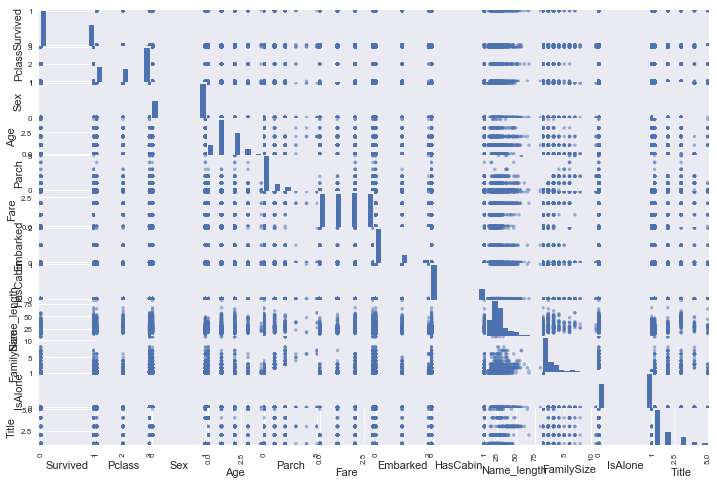

In [43]:
from pandas.plotting import scatter_matrix

attributes = train_set.columns.values
scatter_matrix(train_set[attributes], figsize=(12, 8))

In [44]:
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Title          0.385627
HasCabin       0.324061
Name_length    0.319479
Fare           0.280904
Embarked       0.133443
Parch          0.104591
FamilySize     0.026775
Age           -0.056891
IsAlone       -0.215998
Pclass        -0.327891
Sex           -0.531922
Name: Survived, dtype: float64